In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
new_car= pd.read_csv(Path("./Resources/new_cars_prices.csv"))
used_car= pd.read_csv(Path("./Resources/used_car_prices.csv"))
car_data= pd.read_csv(Path("./Resources/car_prices.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'Resources/new_cars_prices.csv'

In [3]:
car_data = car_data.drop(columns=['vin','saledate',], axis=1)
car_data.dropna(inplace=True)

In [4]:
car_data

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558831,2011,BMW,5 Series,528i,Sedan,automatic,fl,39.0,66403.0,white,brown,lauderdale imports ltd bmw pembrok pines,20300.0,22800.0
558833,2012,Ram,2500,Power Wagon,Crew Cab,automatic,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0
558834,2012,BMW,X5,xDrive35d,SUV,automatic,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0
558835,2015,Nissan,Altima,2.5 S,sedan,automatic,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0


In [5]:
car_data.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
dtype: object

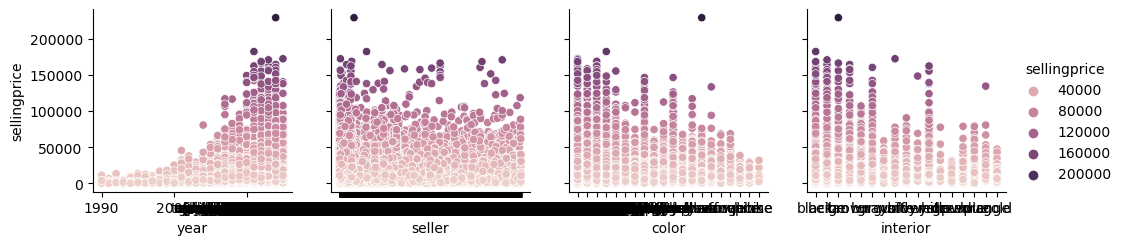

In [6]:
x_vars= ["year","seller", "color", "interior"]
y_vars= ["sellingprice"]
g= sns.PairGrid(car_data, hue="sellingprice", x_vars=x_vars, y_vars=y_vars)
g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
